In [1]:
import pandas as pd
import numpy as np
import conn
import logging
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_gstc_code(code):
    try:
        conn.connect_to_database()
        query = f'''
            SELECT ts.GSTC_CODE
              FROM TB_STOCKCLASSIFY ts
             WHERE ts.KSTC_CODE = '{code}'
        '''
        
        conn.global_cursor.execute(query)
        df = pd.read_sql(query, conn.global_conn)
        
        return df
    except Exception as e:
        logging.error(f'Error occurred while fetching data from database: {e}')
        return None
    finally:
        conn.close_database_connection()

In [3]:
df = get_gstc_code('005930')

MariaDB 서버에 성공적으로 연결되었습니다. 서버 버전: 10.4.34-MariaDB
현재 사용 중인 데이터베이스: cryptoStockTrading
MariaDB 연결이 종료되었습니다.


In [4]:
def select_data(gstc_code):
    try:
        conn.connect_to_database()
        query = f'''
            SELECT td.STCK_BSOP_DATE, td.STCK_CLPR, td.STCK_OPRC, td.STCK_HGPR, td.STCK_LWPR, td.ACML_VOL, td.ACML_TR_PBMN
              FROM TB_DAILYSTOCK td
             WHERE td.GSTC_CODE = '{gstc_code}'
             ORDER BY td.STCK_BSOP_DATE ASC
        '''
        
        conn.global_cursor.execute(query)
        df = pd.read_sql(query, conn.global_conn)
        
        return df
    except Exception as e:
        logging.error(f'Error occurred while fetching data from database: {e}')
        return None
    finally:
        conn.close_database_connection()

In [5]:
gstc_code = df.iloc[0,0]

In [6]:
data = select_data(gstc_code)

MariaDB 서버에 성공적으로 연결되었습니다. 서버 버전: 10.4.34-MariaDB
현재 사용 중인 데이터베이스: cryptoStockTrading
MariaDB 연결이 종료되었습니다.


In [7]:
data = data.drop_duplicates(subset='STCK_BSOP_DATE')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6107 entries, 0 to 6109
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   STCK_BSOP_DATE  6107 non-null   object
 1   STCK_CLPR       6107 non-null   object
 2   STCK_OPRC       6107 non-null   object
 3   STCK_HGPR       6107 non-null   object
 4   STCK_LWPR       6107 non-null   object
 5   ACML_VOL        6107 non-null   object
 6   ACML_TR_PBMN    6107 non-null   object
dtypes: object(7)
memory usage: 381.7+ KB


In [9]:
data.head()

,STCK_BSOP_DATE,STCK_CLPR,STCK_OPRC,STCK_HGPR,STCK_LWPR,ACML_VOL,ACML_TR_PBMN
0,20000104,6110,6000,6110,5660,74198352,444233178500
1,20000105,5580,5800,6060,5520,74680200,433783381000
2,20000106,5620,5750,5780,5580,54390500,308005325000
3,20000107,5540,5560,5670,5360,40309752,222717840000
4,20000110,5770,5600,5770,5580,46880752,265754492500


In [10]:
# 날짜 변환 및 정렬
data['STCK_BSOP_DATE'] = pd.to_datetime(data['STCK_BSOP_DATE'], format='%Y%m%d')
data = data.sort_values('STCK_BSOP_DATE').reset_index(drop=True)

# 데이터 타입 변환
columns_to_convert = ['STCK_CLPR', 'STCK_OPRC', 'STCK_HGPR', 'STCK_LWPR', 'ACML_VOL', 'ACML_TR_PBMN']
data[columns_to_convert] = data[columns_to_convert].astype(float)

In [11]:
# 1. 타겟 변수 변경: 5일 후의 종가를 기준으로 라벨 생성
data['future_close'] = data['STCK_CLPR'].shift(-5)  # 5일 후 종가
data['label'] = np.where(data['future_close'] > data['STCK_CLPR'], 1, 0)
data = data.dropna(subset=['future_close']).reset_index(drop=True)  # NaN 제거

In [12]:
data.head()

,STCK_BSOP_DATE,STCK_CLPR,STCK_OPRC,STCK_HGPR,STCK_LWPR,ACML_VOL,ACML_TR_PBMN,future_close,label
0,2000-01-04,6110.0,6000.0,6110.0,5660.0,74198352.0,4.442332e+11,5770.0,0
1,2000-01-05,5580.0,5800.0,6060.0,5520.0,74680200.0,4.337834e+11,5720.0,1
2,2000-01-06,5620.0,5750.0,5780.0,5580.0,54390500.0,3.080053e+11,5710.0,1
3,2000-01-07,5540.0,5560.0,5670.0,5360.0,40309752.0,2.227178e+11,5830.0,1
4,2000-01-10,5770.0,5600.0,5770.0,5580.0,46880752.0,2.657545e+11,6100.0,1


In [13]:
# 2. 추가적인 특징(feature) 생성

# 기존 기술적 지표
# Moving Averages
data['MA5'] = data['STCK_CLPR'].rolling(window=5).mean()
data['MA10'] = data['STCK_CLPR'].rolling(window=10).mean()
data['MA20'] = data['STCK_CLPR'].rolling(window=20).mean()
data['MA50'] = data['STCK_CLPR'].rolling(window=50).mean()

# Exponential Moving Averages
data['EMA5'] = data['STCK_CLPR'].ewm(span=5, adjust=False).mean()
data['EMA10'] = data['STCK_CLPR'].ewm(span=10, adjust=False).mean()
data['EMA20'] = data['STCK_CLPR'].ewm(span=20, adjust=False).mean()

# Relative Strength Index (RSI)
delta = data['STCK_CLPR'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down
data['RSI'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
exp1 = data['STCK_CLPR'].ewm(span=12, adjust=False).mean()
exp2 = data['STCK_CLPR'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
data['20_day_MA'] = data['STCK_CLPR'].rolling(window=20).mean()
data['20_day_STD'] = data['STCK_CLPR'].rolling(window=20).std()
data['Bollinger_High'] = data['20_day_MA'] + (data['20_day_STD'] * 2)
data['Bollinger_Low'] = data['20_day_MA'] - (data['20_day_STD'] * 2)

# Stochastic Oscillator
low14 = data['STCK_LWPR'].rolling(window=14).min()
high14 = data['STCK_HGPR'].rolling(window=14).max()
data['%K'] = 100 * ((data['STCK_CLPR'] - low14) / (high14 - low14))
data['%D'] = data['%K'].rolling(window=3).mean()

# 새로운 특징 추가
# 가격 변동률
data['price_change'] = data['STCK_CLPR'].pct_change()

# 변동성 (10일 기준)
data['volatility'] = data['STCK_CLPR'].rolling(window=10).std()

# 시차 특징 (1~5일)
for lag in range(1, 6):
    data[f'lag_{lag}'] = data['STCK_CLPR'].shift(lag)

# 로그 변환 적용 (ACML_VOL, ACML_TR_PBMN)
features_to_log_transform = ['ACML_VOL', 'ACML_TR_PBMN']
data[features_to_log_transform] = data[features_to_log_transform].apply(lambda x: np.log1p(x))

# Drop rows with NaN values resulting from technical indicator and new feature calculations
data = data.dropna().reset_index(drop=True)

In [15]:
# 3. 상관관계 재분석
# 특징과 타겟 변수로 이루어진 데이터프레임 생성
feature_data = data.drop(['STCK_BSOP_DATE', 'future_close', 'future_close'], axis=1)
corr_matrix = feature_data.corr()

# 타겟 변수와의 상관관계 추출 (스피어만 상관계수로 변경)
target_corr = feature_data.corr(method='spearman')['label'].sort_values(ascending=False)
print(target_corr)

label             1.000000
ACML_VOL          0.005448
MACD_signal      -0.005805
20_day_STD       -0.011875
volatility       -0.015888
MACD             -0.016893
Bollinger_High   -0.026720
ACML_TR_PBMN     -0.026897
lag_5            -0.026968
lag_4            -0.026972
Bollinger_Low    -0.027084
lag_3            -0.027141
MA50             -0.027647
MA20             -0.027758
20_day_MA        -0.027758
lag_2            -0.028229
MA10             -0.028429
EMA20            -0.028576
MA5              -0.029228
EMA10            -0.029251
EMA5             -0.029981
lag_1            -0.030196
STCK_OPRC        -0.030333
STCK_HGPR        -0.030590
STCK_LWPR        -0.030593
STCK_CLPR        -0.031366
price_change     -0.036720
RSI              -0.050779
%D               -0.056817
%K               -0.065590
Name: label, dtype: float64


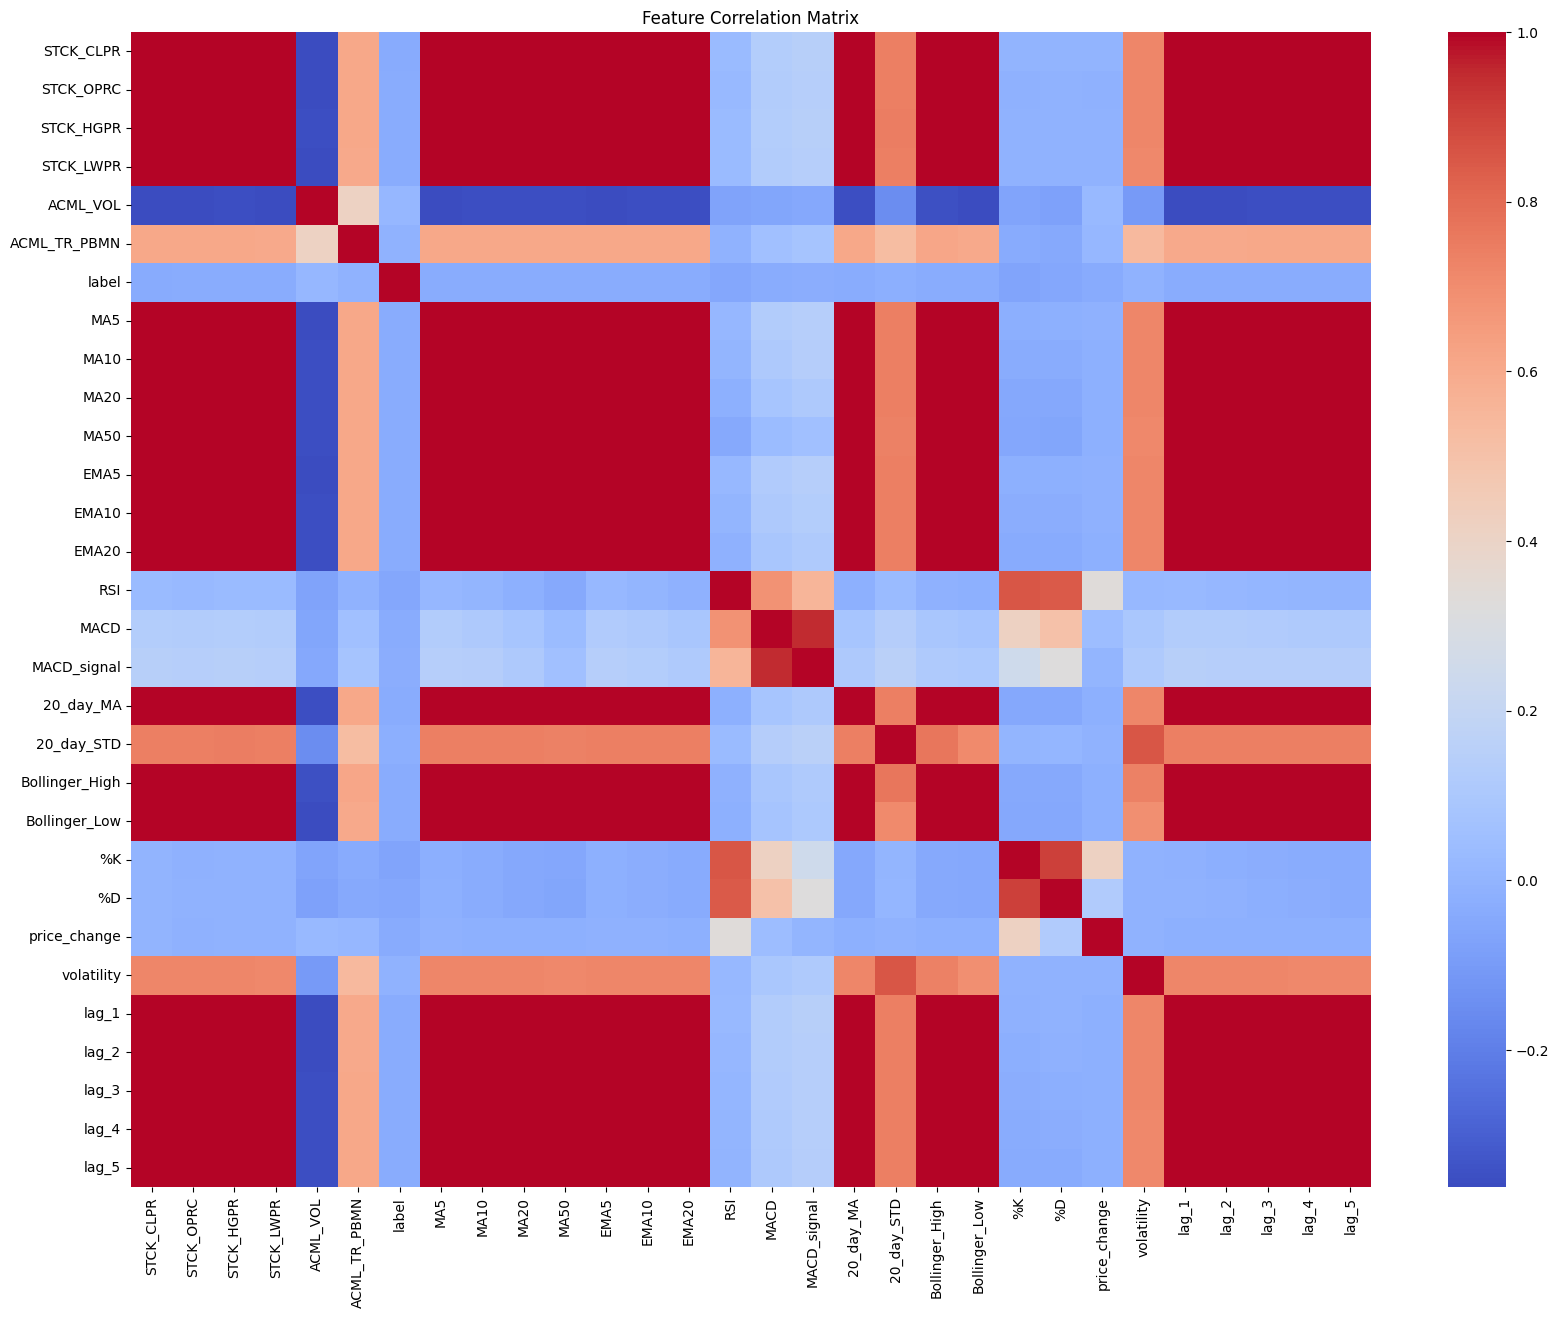

In [16]:
# 상관관계 히트맵 시각화
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [17]:
# 4. 특징 선택 (상관관계가 절댓값 0.05 이상인 특징 선택)
important_features = target_corr[abs(target_corr) > 0.05].index.tolist()
important_features.remove('label')  # 타겟 변수는 제외
print(f"Selected Features ({len(important_features)}): {important_features}")

Selected Features (3): ['RSI', '%D', '%K']


In [18]:
# 선택된 특징만 사용하여 데이터 구성
features = data[important_features].values
labels = data['label'].values

In [19]:
# 5. 시퀀스 길이 변경 (시퀀스 길이를 30으로 증가)
sequence_length = 30  # 30일의 시퀀스

# Create sequences
X = []
y = []
for i in range(sequence_length, len(features)):
    X.append(features[i-sequence_length:i])
    y.append(labels[i])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (6023, 30, 3), y shape: (6023,)


In [20]:
# 6. 데이터 분할 및 스케일링
from sklearn.model_selection import train_test_split

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Reshape for scaling
num_samples_train, num_timesteps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)

# Scaling
scaler = StandardScaler()
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original shape
X_train = X_train_scaled.reshape(num_samples_train, num_timesteps, num_features)
X_test = X_test_scaled.reshape(X_test.shape[0], num_timesteps, num_features)

In [21]:
# 7. PyTorch 텐서로 변환 및 데이터로더 생성
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# 8. 트랜스포머 모델 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))  # [d_model/2]
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, num_timesteps, num_features, feature_size=128, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.feature_size = feature_size

        self.embedding = nn.Linear(num_features, feature_size)
        self.pos_encoder = PositionalEncoding(feature_size, dropout, max_len=num_timesteps)
        encoder_layers = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.decoder = nn.Linear(feature_size, 2)

    def forward(self, src):
        # src shape: [batch_size, seq_len, num_features]
        src = self.embedding(src) * np.sqrt(self.feature_size)
        src = self.pos_encoder(src)
        # Transformer expects input of shape (seq_len, batch_size, d_model)
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src)
        # Take the output from the last time step
        output = output[-1, :, :]
        output = self.decoder(output)
        return output

# Initialize the model
d_model = 128
model = TransformerModel(num_timesteps=sequence_length, num_features=num_features, feature_size=d_model, num_layers=2, dropout=0.1)

In [23]:
# 9. 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TransformerModel(
  (embedding): Linear(in_features=3, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=128, out_features=2, bias=True)
)

In [24]:
# 10. 모델 학습
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.7222
Epoch 2/20, Loss: 0.6960
Epoch 3/20, Loss: 0.6974
Epoch 4/20, Loss: 0.6945
Epoch 5/20, Loss: 0.6941
Epoch 6/20, Loss: 0.6919
Epoch 7/20, Loss: 0.6925
Epoch 8/20, Loss: 0.6906
Epoch 9/20, Loss: 0.6932
Epoch 10/20, Loss: 0.6923
Epoch 11/20, Loss: 0.6923
Epoch 12/20, Loss: 0.6907
Epoch 13/20, Loss: 0.6895
Epoch 14/20, Loss: 0.6897
Epoch 15/20, Loss: 0.6899
Epoch 16/20, Loss: 0.6895
Epoch 17/20, Loss: 0.6898
Epoch 18/20, Loss: 0.6910
Epoch 19/20, Loss: 0.6909
Epoch 20/20, Loss: 0.6920


In [31]:
# 11. 모델 평가 함수 정의
def evaluate(model, loader):
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            probs = torch.softmax(output, dim=1)[:, 1]  # 클래스 1의 확률
            _, predicted = torch.max(output.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    accuracy = correct / total
    roc_auc = roc_auc_score(all_labels, all_probs)
    return accuracy, all_preds, all_labels, roc_auc, all_probs

In [32]:
# 12. 테스트 세트에서 모델 평가
test_accuracy, test_preds, test_labels, test_roc_auc, test_probs = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC-AUC Score: {test_roc_auc:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.4805
Test ROC-AUC Score: 0.4943
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.19      0.27       612
           1       0.48      0.78      0.60       593

    accuracy                           0.48      1205
   macro avg       0.48      0.49      0.43      1205
weighted avg       0.48      0.48      0.43      1205

Confusion Matrix:
[[115 497]
 [129 464]]


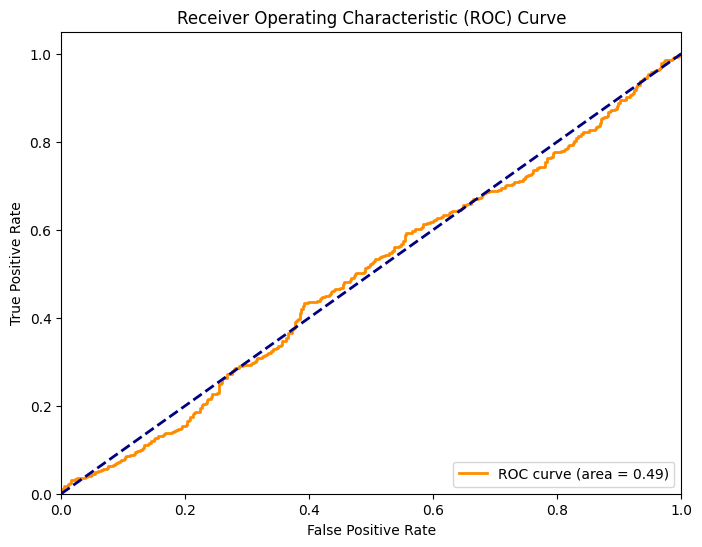

In [33]:
# 13. ROC-AUC 곡선 시각화
from sklearn.metrics import roc_curve, auc

# 'test_probs'를 사용하여 ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

XGBoost Test Accuracy: 0.5029
XGBoost Test ROC-AUC Score: 0.5095
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.48      0.50       612
           1       0.50      0.52      0.51       593

    accuracy                           0.50      1205
   macro avg       0.50      0.50      0.50      1205
weighted avg       0.50      0.50      0.50      1205

XGBoost Confusion Matrix:
[[296 316]
 [283 310]]


<Figure size 1000x600 with 0 Axes>

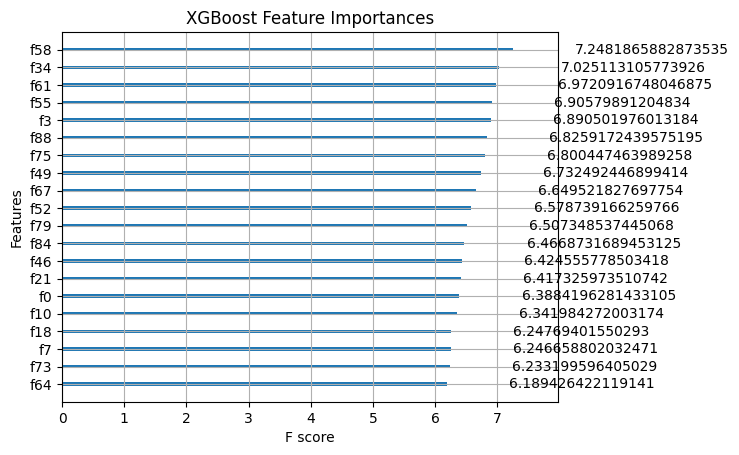

In [34]:
# 14. 피처 중요도 확인을 위한 XGBoost 모델 학습 및 비교
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# 14.1. XGBoost용 데이터 준비 (시퀀스 데이터가 아닌 각 시점의 데이터 사용)
# 시퀀스 데이터를 개별 시점 데이터로 변환
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# XGBoost 모델 학습
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_flat, y_train)

# XGBoost 모델 평가
y_pred_xgb = xgb_model.predict(X_test_flat)
y_probs_xgb = xgb_model.predict_proba(X_test_flat)[:,1]
xgb_accuracy = np.mean(y_pred_xgb == y_test)
xgb_roc_auc = roc_auc_score(y_test, y_probs_xgb)

print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost Test ROC-AUC Score: {xgb_roc_auc:.4f}")
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# 14.2. XGBoost 피처 중요도 시각화
plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title('XGBoost Feature Importances')
plt.show()